# Traitement de données - Stations vélo

Auteur : Tadeusz Plagué--Makowiecki

In [2]:
import requests #request library
from datetime import datetime #useful to create timestamps of collection action
import json
import time 
import sys
# import schedule 
import pandas as pd
import os
import shutil
import csv
import matplotlib.pyplot as plt

## Fonctions

## Code

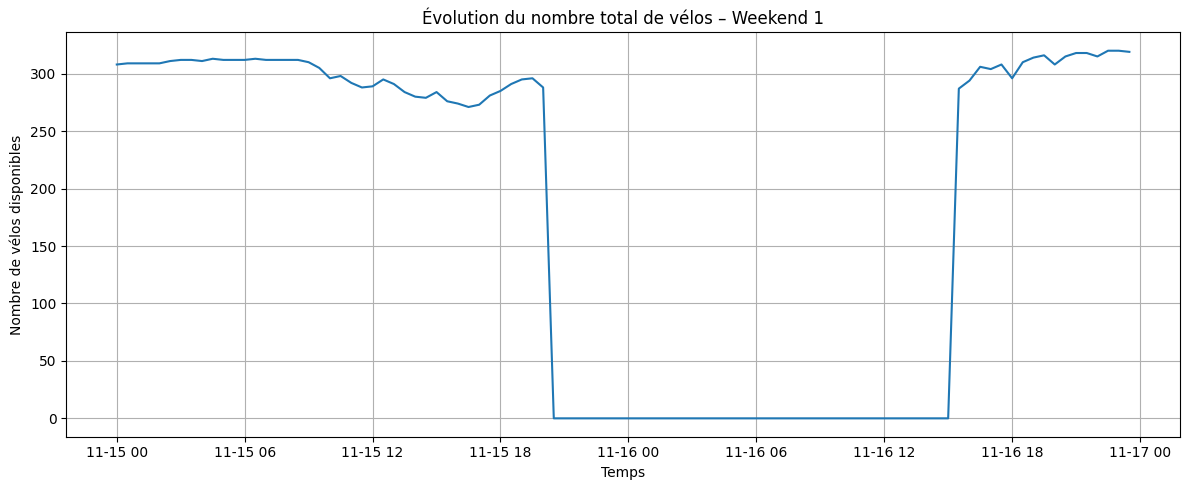

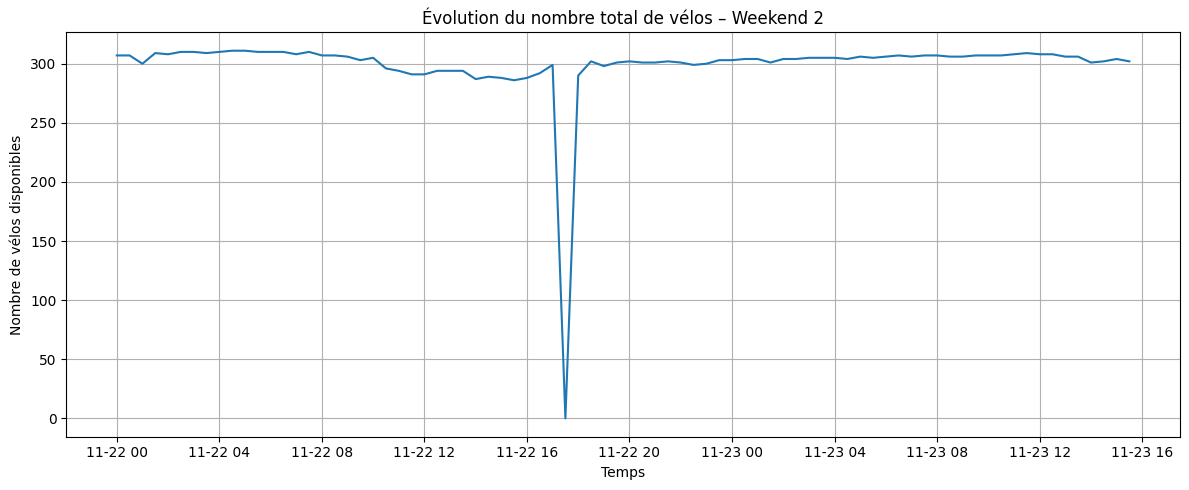

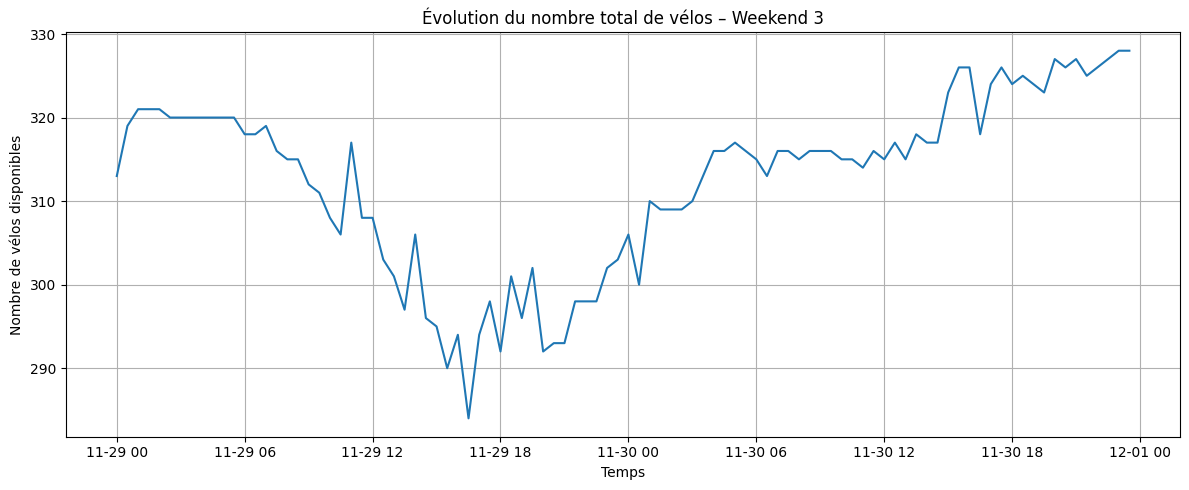

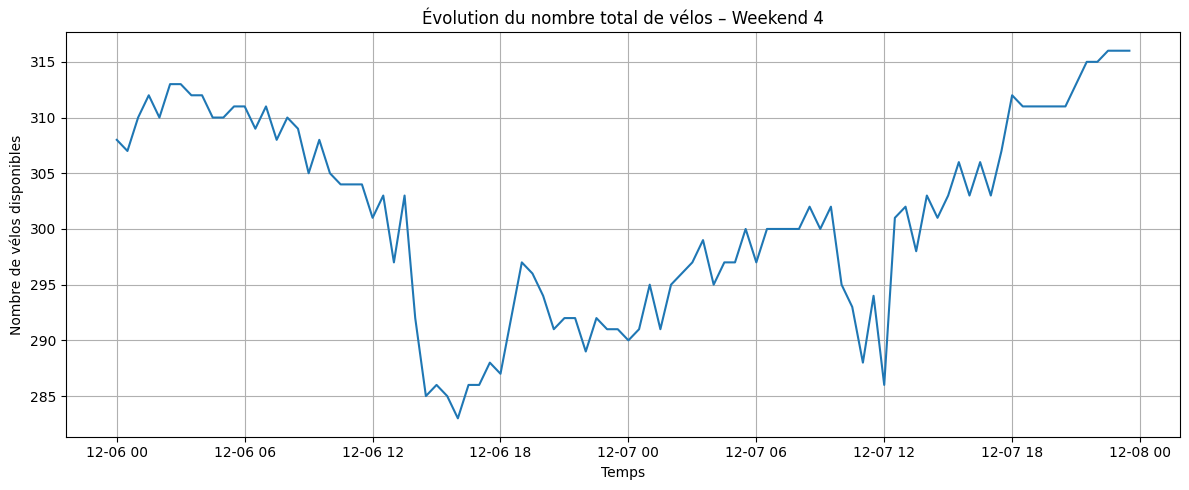

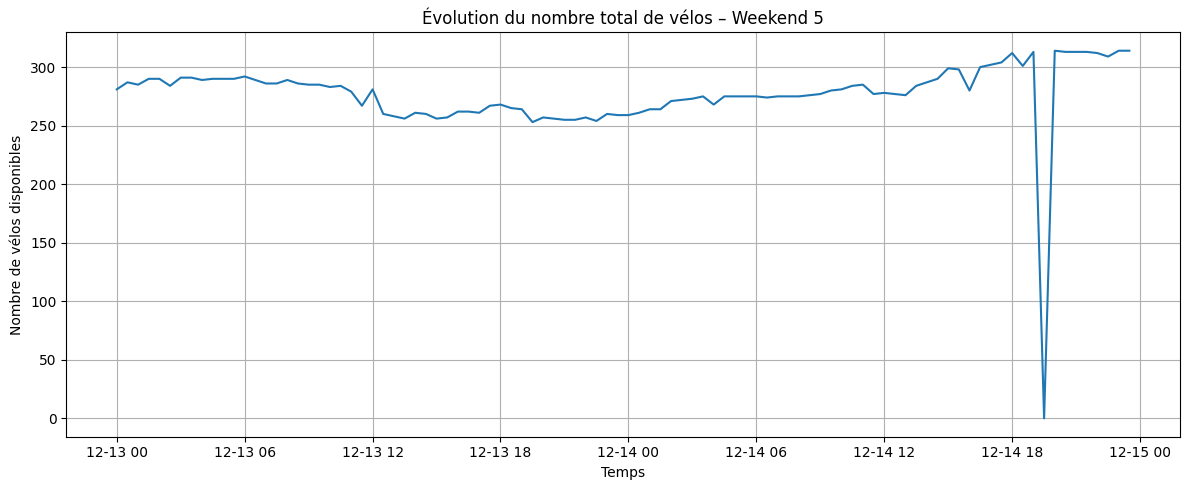

In [3]:
FICHIER = "api_velo_maj_2025_12_17.csv"
df = pd.read_csv(FICHIER, sep=";")

# ===============================
# 2. Sélection et préparation
# ===============================

# Conversion de la colonne temporelle
df["time"] = pd.to_datetime(df["time"], format="%d/%m/%Y %H:%M")

# Suppression des lignes sans date
df = df.dropna(subset=["time"])

# Conversion du nombre de vélos en numérique
df["av"] = pd.to_numeric(df["av"], errors="coerce").fillna(0)
df["lat"] = pd.to_numeric(df["lat"], errors="coerce")
df["lon"] = pd.to_numeric(df["lon"], errors="coerce")

# ===============================
# 3. Définition de séparations
# ===============================

zones = {
    "Zone 1": {"lat_min": 48.574000,"lat_max": 48.589548,"lon_min": 7.729512,"lon_max": 7.761337,
    },
    "Zone 2": {"lat_min": 48.546028,"lat_max": 48.614336,"lon_min": 7.708821,"lon_max": 7.773942,
    },
    "Zone 3": {"lat_min": 48.508347,"lat_max": 48.642825,"lon_min": 7.655548,"lon_max": 7.801724,
    }
}

semaines = {
    "Semaine 1": {"start_date": datetime(2025, 11, 12, 20, 35), "end_date": datetime(2025, 11, 14, 23, 59) 
    },
    "Semaine 2": {"start_date": datetime(2025, 11, 17, 00, 00), "end_date": datetime(2025, 11, 21, 23, 59)
    },
    "Semaine 3": {"start_date": datetime(2025, 11, 24, 00, 00), "end_date": datetime(2025, 11, 28, 23, 59)
    },
    "Semaine 4": {"start_date": datetime(2025, 12, 1, 00, 00), "end_date": datetime(2025, 12, 5, 23, 59)
    },
    "Semaine 5": {"start_date": datetime(2025, 12, 8, 00, 00), "end_date": datetime(2025, 12, 12, 23, 59)
    },
    "Semaine 6": {"start_date": datetime(2025, 12, 15, 00, 00), "end_date": datetime(2025, 12, 19, 23, 59)
    }
}

weekends = {
    "Weekend 1": {"start_date": datetime(2025, 11, 15, 00, 00), "end_date": datetime(2025, 11, 16, 23, 59)
    },
    "Weekend 2": {"start_date": datetime(2025, 11, 22, 00, 00), "end_date": datetime(2025, 11, 23, 23, 59)
    },
    "Weekend 3": {"start_date": datetime(2025, 11, 29, 00, 00), "end_date": datetime(2025, 11, 30, 23, 59)
    },
    "Weekend 4": {"start_date": datetime(2025, 12, 6, 00, 00), "end_date": datetime(2025, 12, 7, 23, 59)
    },
    "Weekend 5": {"start_date": datetime(2025, 12, 13, 00, 00), "end_date": datetime(2025, 12, 14, 23, 59)
    },
}



### Fonctions d'attribution


## Zones
def attribuer_zone(row):
    for nom, z in zones.items():
        if (
            z["lat_min"] <= row["lat"] <= z["lat_max"]
            and z["lon_min"] <= row["lon"] <= z["lon_max"]
        ):
            return nom
    return None

df["zone"] = df.apply(attribuer_zone, axis=1)

# On garde uniquement les stations dans une zone
df = df.dropna(subset=["zone"])

## Semaines
def attribuer_semaine(row):
    for nom, z in semaines.items():
        if (z["start_date"] <= row["time"] <= z["end_date"]):
            return nom
    return None

df["semaine"] = df.apply(attribuer_semaine, axis=1)


## Weekends
def attribuer_weekend(row):
    for nom, z in weekends.items():
        if (z["start_date"] <= row["time"] <= z["end_date"]):
            return nom
    return None

df["weekend"] = df.apply(attribuer_weekend, axis=1)




### Agrégation temporelle

# Mise de la date en index
df = df.set_index("time").sort_index()

# Regroupement par période temporelle et somme, 30min = 30 minutes

periode = "30min"
velos_par_zone = (df.groupby("zone").resample(periode)["av"].sum().reset_index())

velos_par_semaine = (df.groupby("semaine").resample(periode)["av"].sum().reset_index())

velos_par_weekend = (df.groupby("weekend").resample(periode)["av"].sum().reset_index())


### Visualisation



for weekend in velos_par_weekend["weekend"].unique():
    data_weekend = velos_par_weekend[velos_par_weekend["weekend"] == weekend]

    plt.figure(figsize=(12, 5))
    plt.plot(data_weekend["time"], data_weekend["av"])
    plt.title(f"Évolution du nombre total de vélos – {weekend}")
    plt.xlabel("Temps")
    plt.ylabel("Nombre de vélos disponibles")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"evolution_velos_{weekend}.png", dpi=300)
    plt.show()

datetime.datetime(2025, 11, 12, 20, 35)